In [130]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [131]:
data_sept= pd.read_csv("./data/raw/8_SECONDS_DATA_SEPTEMBER.csv")
data_june= pd.read_csv("./data/raw/8_SECONDS_DATA_JUNE.csv")
data_res= pd.read_csv("./data/raw/15 MINUTES DATA.csv") 
identifiers_columns = ['DEVICE_B1_NAME', 'DEVICE_B2_NAME', 'DEVICE_B3_NAME','DEVICE_SCADA_B2_NAME','DEVICE_SCADA_B3_NAME', 'RES_TYPE']#, 'LR_LFCMX']
data_columns = ['SETPOINT_BINOUT', 'SCADA_SETPOINT_FB', 'GROSS_VALUE', 'WINDC_ON', 'WINCSUSP']
print(len(data_sept))
print(len(data_june))

1048575
1048575


In [132]:
print(data_sept.head())

   HIST_TIMESTAMP  DAILYSAVINGTIME_SK DEVICE_B1_NAME DEVICE_B2_NAME  \
0  01-09-24 11:10                   3       ??.?????            ??1   
1  01-09-24 11:10                   3       ??.?????            ??1   
2  01-09-24 11:10                   3       ??.?????            ??1   
3  01-09-24 11:10                   3       ??.?????            ??1   
4  01-09-24 11:11                   3       ??.?????            ??1   

  DEVICE_B3_NAME DEVICE_SCADA_B2_NAME DEVICE_SCADA_B3_NAME RES_TYPE  LR_LFCMX  \
0           GFC1                  PLC             ????????       PV        16   
1           GFC1                  PLC             ????????       PV        16   
2           GFC1                  PLC             ????????       PV        16   
3           GFC1                  PLC             ????????       PV        16   
4           GFC1                  PLC             ????????       PV        16   

   SETPOINT_BINOUT  SCADA_SETPOINT_FB  GROSS_VALUE  WINDC_ON  WINCSUSP  
0            

In [133]:
def initial_assets(df, identity_columns):
    # Check unique combinations of the specified columns
    unique_count = df[identity_columns].drop_duplicates().shape[0]
    print(f"Number of total initial assets {identity_columns}: {unique_count}")



In [134]:
def check_values(df):
    a = len(df)
    print(a)
    print(df.isna().sum())
    df.drop_duplicates(inplace= True)
    b = len(df)
    print(b)
    df.dropna(inplace= True)
    c = len(df)
    print(c)
    df = df[(df['LR_LFCMX'] - df['SETPOINT_BINOUT'] > 1) & # Choose the resources that were selected for curtailment
           (df['WINDC_ON'] != 0) & # Exclude cases that cannot receive curtailment BINOUT command
           (df['WINCSUSP'] != 1) & # Exclude cases that cannot receive curtailment BINOUT command
           (df['SCADA_SETPOINT_FB'] - df['SETPOINT_BINOUT'] <= 2) & # SCADA should slightly less than BINOUT due to cable losses
           (df['GROSS_VALUE'] > 0.1) & # Exclude resources that have a problem or are switched off
           (df['LR_LFCMX'] != 0)
           ]
    
    d = len(df)
    print(d)

    print(f'Number of duplicates: {b-a}')
    print(f'Number of nan values: {c-b}')
    print(f'Number of rows filtered by rules: {d-c}')
    
    return df

In [135]:
def group_by(df):

    # Calculate Curtailment Metrics
    df['Curtailment_amount'] = df['LR_LFCMX'] - df['GROSS_VALUE'] # the curtailment amount for each asset
    # df['Curtailment_amount'] = df['GROSS_VALUE'] - df['SCADA_SETPOINT_FB'] # the curtailment amount for each asset
    df['Curtailment_ratio %'] = (df['Curtailment_amount'] / df['LR_LFCMX']) * 100 # the percentage for each asset's capacity curtailment
    df['Size'] = df['LR_LFCMX'].apply(lambda x: 'Small' if x <= 25 else 'Medium' if 26 <= x <= 50 else 'Large')
        
    # Remove outliers
    # Remove rows where either 'Curtailment_amount' or 'Curtailment_ratio %' is less than or equal to -10
    df = df[(df['Curtailment_amount'] > 0) & (df['Curtailment_ratio %'] > 0)]

    # Group by the recognizing parameters
    groups = df.groupby(identifiers_columns).agg(
        Avg_curtailment_amount=('Curtailment_amount', 'mean'),  # Average curtailment amount
        Avg_curtailment_ratio=('Curtailment_ratio %', 'mean'),  # Average curtailment ratio
        Avg_gross_value=('GROSS_VALUE', 'mean'), # Average gross value
        Max_capacity=('LR_LFCMX', 'first'), # Take the first value of the max capacity
        Size=('Size', 'first') # Take the first value of the size
    )

    # Remove decimals
    groups['Max_capacity'] = groups['Max_capacity'].astype(int)
    # Add resource ids 1 - 228
    groups['Resource_ID'] = range(1, len(groups) +1)

    print(groups.head(2))
    print("Number of total assets for analysis: ",len(groups))
    
    # groups.set_index('Resource_ID', inplace= True)
    return groups

    # print(groups.index)
    # for name, group in groups.iterrows():
    #     print(f"Group Name: {name}, Avg Curtailment Amount: {group['Avg_curtailment_amount']}, Avg Curtailment Ratio: {group['Avg_curtailment_ratio']}")

In [136]:
def plot_avgca(groups, month):
    # Sort the average curtailment amount
    sorted_avgcr = groups.sort_values(by='Avg_curtailment_amount', ascending=False)

    # Now extract RES_TYPE from the index
    res_types = sorted_avgcr.index.get_level_values('RES_TYPE')

    # Create a color list for the bars based on RES_TYPE
    bar_colors = ['yellow' if res_type == 'PV' else 'green' for res_type in res_types]

    handles = [plt.Rectangle((0, 0), 1, 1, color='yellow', alpha=0.7), 
            plt.Rectangle((0, 0), 1, 1, color='green', alpha=0.7)]
    
    labels = ['PV', 'WIND']

    # Plotting the Avg Curtailment Amount
    fig = plt.figure(figsize=(10, 6))

    # Use a bar plot for clarity with colors for each RES_TYPE
    plt.bar(sorted_avgcr['Resource_ID'].astype(str), sorted_avgcr['Avg_curtailment_amount'], color=bar_colors, alpha=0.7)

    # Set plot title and labels
    plt.title(f'Average Curtailment Amount by Resource - {month}')
    plt.xlabel('Resource ID')
    plt.ylabel('Average Curtailment amount (MW)')
    plt.xticks(rotation=45)  # Rotate x-tick labels for better readability
    plt.grid(axis='y')  # Add a grid for better readability
    # Create a legend for RES_TYPE
    plt.legend(handles, labels, title="RES_TYPE")
    plt.show()  # Show the plot

In [137]:
def plot_size_curtailment_violin_swarm_plot(groups, month):
    # Compute the average curtailment ratio for each 'Size' category
    avg_curtailment_by_size = groups.groupby('Size')['Avg_curtailment_ratio'].mean()

    # Sort the categories by average curtailment ratio in ascending order
    sorted_sizes = avg_curtailment_by_size.sort_values().index

    # Define custom colors for each 'Size' category (ensure these match the exact values in your data)
    size_colors = {
        'Small': 'green',
        'Medium': 'orange',
        'Large': 'red'  # Update this key based on the exact value in your data
    }

    # Create the figure
    plt.figure(figsize=(12, 8))

    # Create the violin plot, with the sizes sorted by average curtailment ratio
    sns.violinplot(
        x='Size', 
        y='Avg_curtailment_ratio', 
        data=groups, 
        palette=size_colors,  # Apply the custom colors
        order=sorted_sizes
    )

    # Overlay the swarm plot to show individual data points, with the same colors
    sns.swarmplot(
        x='Size', 
        y='Avg_curtailment_ratio', 
        data=groups, 
        color='black',  # Color of the points on top of the violin plot
        alpha=0.6, 
        dodge=True
    )

    # Set plot title and labels
    plt.title(f'Curtailment Ratio Distribution by Asset Size - {month}')
    plt.xlabel('Asset Size')
    plt.ylabel('Curtailment Ratio (%)')
    plt.grid(True, axis='y')  # Add grid for better readability

    # Display the plot
    plt.show()

In [138]:
def plot_size_curtailment(groups, month):
    # Group by 'Size' and calculate the average curtailment ratio
    size_group = groups.groupby('Size').agg(
        Avg_size_curtailment_ratio=('Avg_curtailment_ratio', 'mean')
    )
    size_group = size_group.sort_values(by='Avg_size_curtailment_ratio')
    
    # Count occurrences of each Size group in the original data
    size_counts = groups['Size'].value_counts()

    # Define custom colors based on size category
    size_colors = {
        'Small': 'orange',
        'Medium': 'green',
        'Large': 'red'
    }

    # Map the sizes to the colors
    bar_colors = [size_colors.get(size, 'red') for size in size_group.index]

    # Create the figure
    fig = plt.figure(figsize=(10, 6))

    # Create the bar plot: X-axis is size group names, Y-axis is Avg_curtailment_ratio
    bars = plt.bar(size_group.index, size_group['Avg_size_curtailment_ratio'], color=bar_colors, alpha=0.7)

    # Set plot title and labels
    plt.title(f'Average Curtailment Ratio by Asset Size - {month}')
    plt.xlabel('Asset Size')
    plt.ylabel('Average Curtailment Ratio (%)')
    plt.xticks(rotation=45)  # Rotate x-tick labels for better readability
    plt.grid(axis='y')  # Add a grid for better readability

    # Add percentage and count labels on top of each bar
    for bar, size in zip(bars, size_group.index):
        # Get the height of each bar (Average Curtailment Ratio) and the count from size_counts
        height = bar.get_height()
        count = size_counts.get(size, 0)  # Fetch the count for each size category
        # Annotate with percentage and count
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X position of the text (center of the bar)
            height + 0.5,  # Y position of the text (slightly above the bar)
            f'{height:.2f}% ({count})',  # Display percentage and count
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment
            fontsize=10,  # Font size for readability
            color='black'  # Text color
        )

    # Display the plot
    plt.show()


In [139]:
def plot_avgcr(groups, month):
    # Sort the average curtailment amount
    sorted_avgcr = groups.sort_values(by='Avg_curtailment_ratio', ascending=False)

    # Now extract RES_TYPE from the index
    res_types = sorted_avgcr.index.get_level_values('RES_TYPE')

    # Create a color list for the bars based on RES_TYPE
    bar_colors = ['red' if res_type == 'PV' else 'blue' for res_type in res_types]

    handles = [plt.Rectangle((0, 0), 1, 1, color='red', alpha=0.7), 
            plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.7)]
    labels = ['PV', 'WIND']

    # Plotting the Avg Curtailment Amount
    fig = plt.figure(figsize=(10, 6))

    # Use a bar plot for clarity with colors for each RES_TYPE
    plt.bar(sorted_avgcr['Resource_ID'].astype(str), sorted_avgcr['Avg_curtailment_ratio'], color=bar_colors, alpha=0.7)
    
    # Set plot title and labels
    plt.title(f'Average Curtailment ratio by Resource - {month}')
    plt.xlabel('Resource ID')
    plt.ylabel('Average Curtailment ratio %')
    plt.xticks(rotation=45)  # Rotate x-tick labels for better readability
    plt.grid(axis='y')  # Add a grid for better readability
    # Create a legend for RES_TYPE
    plt.legend(handles, labels, title="RES_TYPE")
    plt.show()  # Show the plot

In [140]:
def plot_res_avgcr(df, month):
    # If 'RES_TYPE' is already a column, drop it first to avoid duplication
    if 'RES_TYPE' in df.columns:
        df = df.drop(columns=['RES_TYPE'])
    
    # Reset the index to make 'RES_TYPE' a column rather than an index level
    df_reset = df.reset_index()
    
    # Group by 'RES_TYPE' and calculate the average of 'Avg_curtailment_ratio'
    avg_curtailment_by_res = df_reset.groupby('RES_TYPE')['Avg_curtailment_ratio'].mean()

    # Set bar colors based on RES_TYPE index
    bar_colors = ['yellow' if res_type == 'PV' else 'green' for res_type in avg_curtailment_by_res.index]

    # Legend handles and labels for RES_TYPE
    handles = [
        plt.Rectangle((0, 0), 1, 1, color='yellow', alpha=0.7), 
        plt.Rectangle((0, 0), 1, 1, color='green', alpha=0.7)
    ]
    labels = ['PV', 'WIND']
    
    # Create the bar plot
    ax = avg_curtailment_by_res.plot(kind='bar', color=bar_colors, edgecolor='black')
    
    # Set plot labels and title
    plt.xlabel('Resource Type')
    plt.ylabel('Average Curtailment Ratio (%)')
    plt.title(f'Average Curtailment Ratio by Resource Type (PV or WIND) - {month}')
    
    # Annotate each bar with the percentage value
    for idx, value in enumerate(avg_curtailment_by_res):
        ax.text(
            idx, value + 0.5, f'{value:.2f}%',  # Position and formatting
            ha='center', va='bottom', fontsize=10, color='black'
        )
    
    # Add the legend
    plt.legend(handles=handles, labels=labels)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [141]:
def plot_heatmap(df, month):

    columns_for_heatmap = ['Curtailment_amount', 'Curtailment_ratio %', 'GROSS_VALUE', 'LR_LFCMX', 'SETPOINT_BINOUT', 'SCADA_SETPOINT_FB']
    heatmap_data = df[columns_for_heatmap].corr()  # Compute the correlation matrix
    # Plotting the correlation heatmap
    mask = np.triu(np.ones_like(heatmap_data, dtype=bool))

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)
    plt.title(f'Correlation Heatmap of Key Parameters - {month}')
    plt.show()

In [142]:
def plot_maxcap_avgcr(groups, month):
    # Sort by Avg_curtailment_ratio in descending order for better visual clarity
    sorted_avgcr = groups.sort_values(by='Avg_curtailment_ratio', ascending=False)

    # Extract RES_TYPE and LR_LFCMX from the multi-index
    res_types = sorted_avgcr.index.get_level_values('RES_TYPE')
    # max_capacity = sorted_avgcr.index.get_level_values('LR_LFCMX')

    # # Sort max_capacity
    # sorted_max_capacity = max_capacity.sort_values()

    # Define bar colors based on RES_TYPE
    bar_colors = ['orange' if res_type == 'PV' else 'lightblue' for res_type in res_types]

    # Legend handles and labels for RES_TYPE
    handles = [
        plt.Rectangle((0, 0), 1, 1, color='orange', alpha=0.7), 
        plt.Rectangle((0, 0), 1, 1, color='lightblue', alpha=0.7)
    ]
    labels = ['PV', 'WIND']

    # Plotting the Avg_curtailment_ratio with different colors for each RES_TYPE
    fig1 = plt.figure(figsize=(10, 6))
    plt.bar(sorted_avgcr['Max_capacity'], sorted_avgcr['Avg_curtailment_ratio'], color=bar_colors, alpha=0.7)

    # Set plot title and labels
    plt.title(f"Asset's capacity Average Curtailment ratio - {month}")
    plt.xlabel("Max capacity")
    plt.xlim(right = 100)
    plt.ylabel('Average Curtailment Ratio (%)')
    plt.ylim(top = 100)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.4)  # Add a grid for readability

    # Add a legend for RES_TYPE
    plt.legend(handles, labels, title="RES_TYPE")

    # Display the plot
    plt.show()
# def plot_maxcap_avgcr(groups):
#     # Sort by Avg_curtailment_ratio in descending order for better visual clarity
#     sorted_avgcr = groups.sort_values(by='Avg_curtailment_ratio', ascending=False)

#     # Extract RES_TYPE and LR_LFCMX from the multi-index
#     res_types = sorted_avgcr.index.get_level_values('RES_TYPE')
#     max_capacity = sorted_avgcr.index.get_level_values('LR_LFCMX')

#     # # Sort max_capacity
#     # sorted_max_capacity = max_capacity.sort_values()

#     # Define bar colors based on RES_TYPE
#     bar_colors = ['orange' if res_type == 'PV' else 'lightblue' for res_type in res_types]

#     # Legend handles and labels for RES_TYPE
#     handles = [
#         plt.Rectangle((0, 0), 1, 1, color='orange', alpha=0.7), 
#         plt.Rectangle((0, 0), 1, 1, color='lightblue', alpha=0.7)
#     ]
#     labels = ['PV', 'WIND']

#     # Plotting the Avg_curtailment_ratio with different colors for each RES_TYPE
#     fig1 = plt.figure(figsize=(10, 6))
#     plt.bar(max_capacity, sorted_avgcr['Avg_curtailment_ratio'], color=bar_colors, alpha=0.7)

#     # Set plot title and labels
#     plt.title("Asset's capacity Average Curtailment ratio")
#     plt.xlabel("Max capacity")
#     plt.xlim(right = 100)
#     plt.ylabel('Average Curtailment Ratio (%)')
#     plt.ylim(top = 100)
#     plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#     plt.grid(axis='y', linestyle='--', alpha=0.4)  # Add a grid for readability

#     # Add a legend for RES_TYPE
#     plt.legend(handles, labels, title="RES_TYPE")

#     # Display the plot
#     plt.show()


In [143]:
def count_res_types(df):
    pv_count = sum(df.index.get_level_values('RES_TYPE') == 'PV')
    wind_count = sum(df.index.get_level_values('RES_TYPE') == 'WIND')

    print(f"Number of PV resources: {pv_count}")
    print(f"Number of WIND resources: {wind_count}")


# Dataset for June & September

In [144]:
initial_assets(data_june, identifiers_columns)
initial_assets(data_sept, identifiers_columns)

Number of total initial assets ['DEVICE_B1_NAME', 'DEVICE_B2_NAME', 'DEVICE_B3_NAME', 'DEVICE_SCADA_B2_NAME', 'DEVICE_SCADA_B3_NAME', 'RES_TYPE']: 173
Number of total initial assets ['DEVICE_B1_NAME', 'DEVICE_B2_NAME', 'DEVICE_B3_NAME', 'DEVICE_SCADA_B2_NAME', 'DEVICE_SCADA_B3_NAME', 'RES_TYPE']: 182


In [145]:
df_june = check_values(data_june)


1048575
HIST_TIMESTAMP               0
DAILYSAVINGTIME_SK           0
DEVICE_B1_NAME               0
DEVICE_B2_NAME               0
DEVICE_B3_NAME               0
DEVICE_SCADA_B2_NAME         0
DEVICE_SCADA_B3_NAME         0
RES_TYPE                     0
LR_LFCMX                     0
SETPOINT_BINOUT              0
SCADA_SETPOINT_FB            0
GROSS_VALUE                156
WINDC_ON                523317
WINCSUSP                523494
dtype: int64
516320
259475
162501
Number of duplicates: -532255
Number of nan values: -256845
Number of rows filtered by rules: -96974


In [146]:
df_sept = check_values(data_sept)

1048575
HIST_TIMESTAMP          0
DAILYSAVINGTIME_SK      0
DEVICE_B1_NAME          0
DEVICE_B2_NAME          0
DEVICE_B3_NAME          0
DEVICE_SCADA_B2_NAME    0
DEVICE_SCADA_B3_NAME    0
RES_TYPE                0
LR_LFCMX                0
SETPOINT_BINOUT         0
SCADA_SETPOINT_FB       0
GROSS_VALUE             0
WINDC_ON                0
WINCSUSP                0
dtype: int64
445220
445220
353040
Number of duplicates: -603355
Number of nan values: 0
Number of rows filtered by rules: -92180


In [147]:
groups_june = group_by(df_june)
print(groups_june.columns)

                                                                                                 Avg_curtailment_amount  \
DEVICE_B1_NAME DEVICE_B2_NAME DEVICE_B3_NAME DEVICE_SCADA_B2_NAME DEVICE_SCADA_B3_NAME RES_TYPE                           
??.?????       ??1            GFC1           PLC                  ????????             PV                     12.266583   
               ??2            GFC1           PLC                  ????_1               PV                     35.765866   

                                                                                                 Avg_curtailment_ratio  \
DEVICE_B1_NAME DEVICE_B2_NAME DEVICE_B3_NAME DEVICE_SCADA_B2_NAME DEVICE_SCADA_B3_NAME RES_TYPE                          
??.?????       ??1            GFC1           PLC                  ????????             PV                    76.666145   
               ??2            GFC1           PLC                  ????_1               PV                    70.129150   

                  

C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\1624145817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Curtailment_amount'] = df['LR_LFCMX'] - df['GROSS_VALUE'] # the curtailment amount for each asset
C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\1624145817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Curtailment_ratio %'] = (df['Curtailment_amount'] / df['LR_LFCMX']) * 100 # the percentage for each asset's capacity curtailment
C:\Users\dzagganas.WINCELL\

In [148]:
groups_sept = group_by(df_sept)
print(groups_sept.columns)

C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\1624145817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Curtailment_amount'] = df['LR_LFCMX'] - df['GROSS_VALUE'] # the curtailment amount for each asset
C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\1624145817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Curtailment_ratio %'] = (df['Curtailment_amount'] / df['LR_LFCMX']) * 100 # the percentage for each asset's capacity curtailment


                                                                                                 Avg_curtailment_amount  \
DEVICE_B1_NAME DEVICE_B2_NAME DEVICE_B3_NAME DEVICE_SCADA_B2_NAME DEVICE_SCADA_B3_NAME RES_TYPE                           
??.?????       ??1            GFC1           PLC                  ????????             PV                     11.117145   
               ??2            GFC1           PLC                  ????_1               PV                     30.400410   

                                                                                                 Avg_curtailment_ratio  \
DEVICE_B1_NAME DEVICE_B2_NAME DEVICE_B3_NAME DEVICE_SCADA_B2_NAME DEVICE_SCADA_B3_NAME RES_TYPE                          
??.?????       ??1            GFC1           PLC                  ????????             PV                    69.482155   
               ??2            GFC1           PLC                  ????_1               PV                    59.608646   

                  

C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\1624145817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Size'] = df['LR_LFCMX'].apply(lambda x: 'Small' if x <= 25 else 'Medium' if 26 <= x <= 50 else 'Large')


In [149]:
count_res_types(groups_june)
count_res_types(groups_sept)

Number of PV resources: 40
Number of WIND resources: 123
Number of PV resources: 45
Number of WIND resources: 129


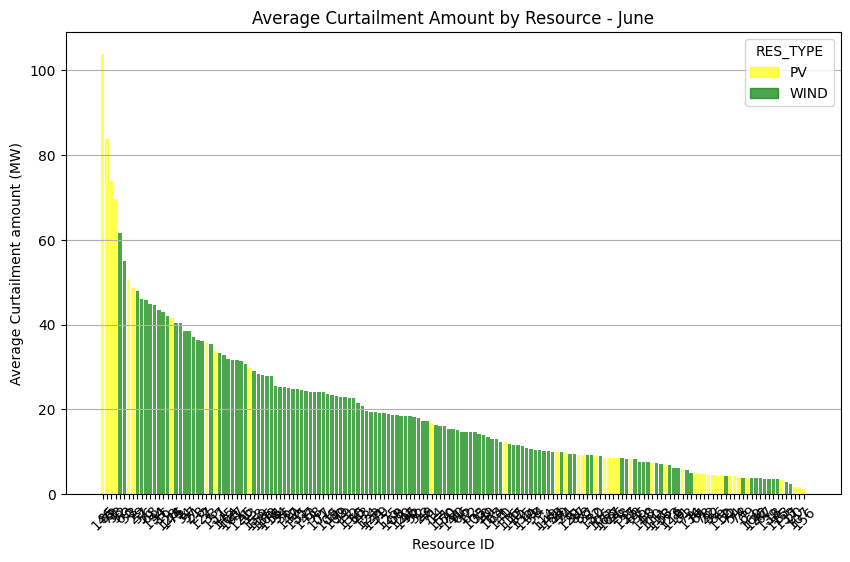

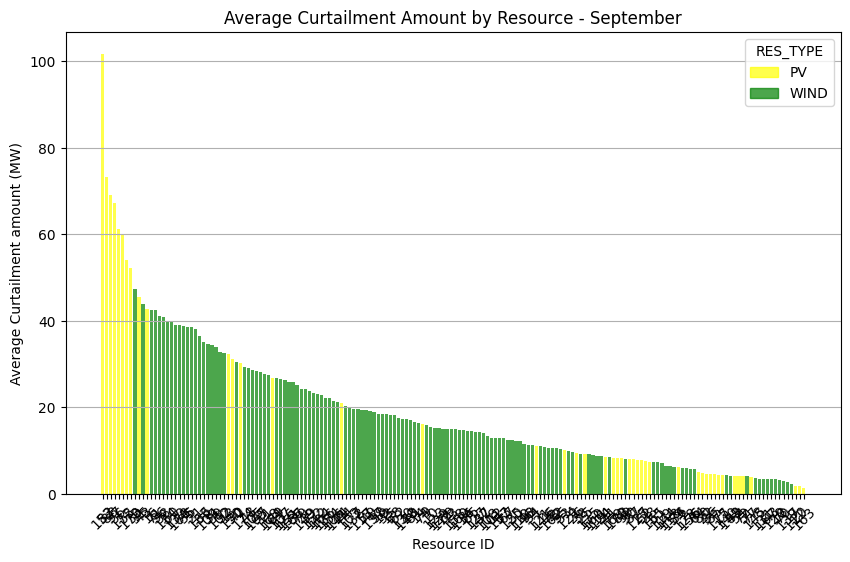

In [150]:
plot_avgca(groups_june, 'June')
plot_avgca(groups_sept, 'September')

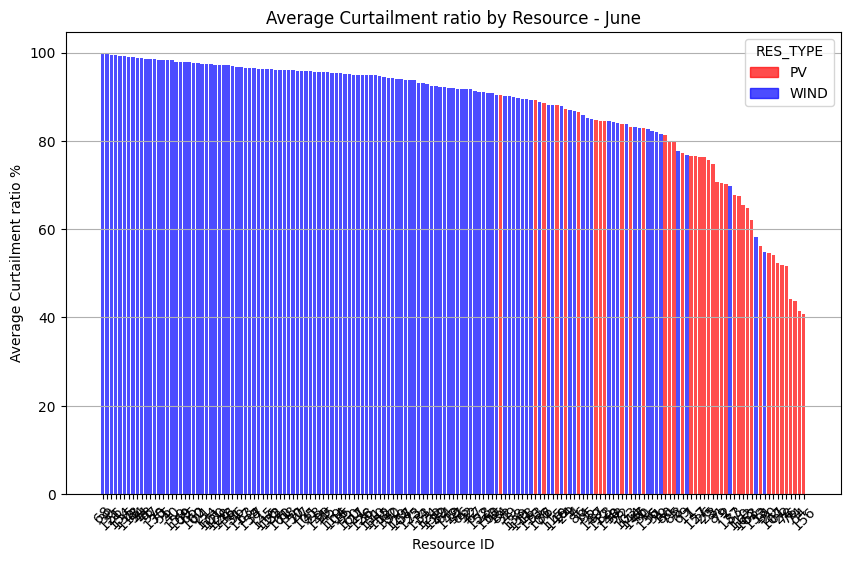

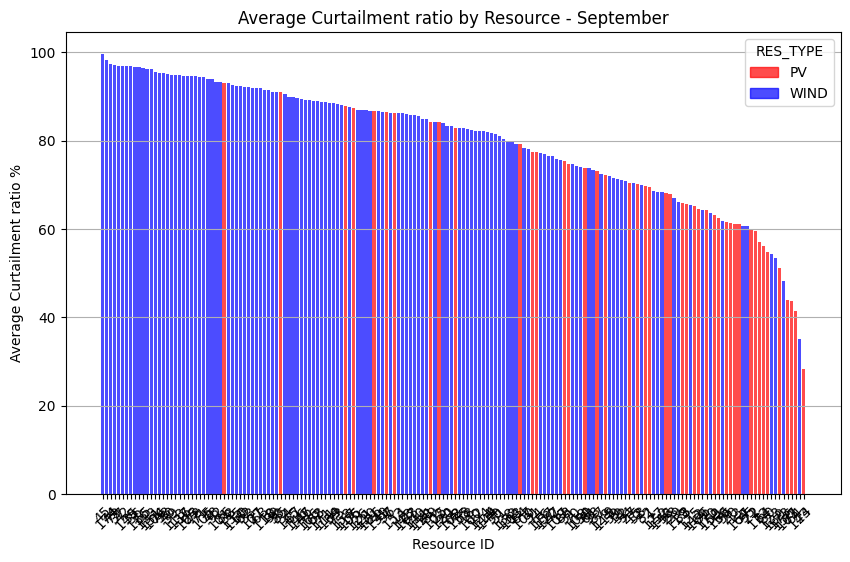

In [151]:
plot_avgcr(groups_june, 'June')
plot_avgcr(groups_sept, 'September')

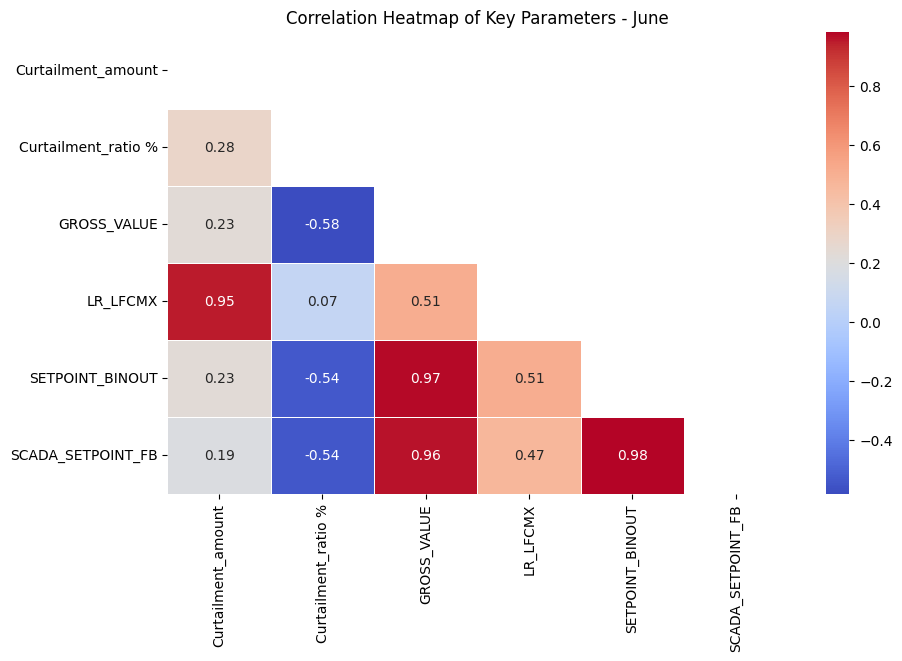

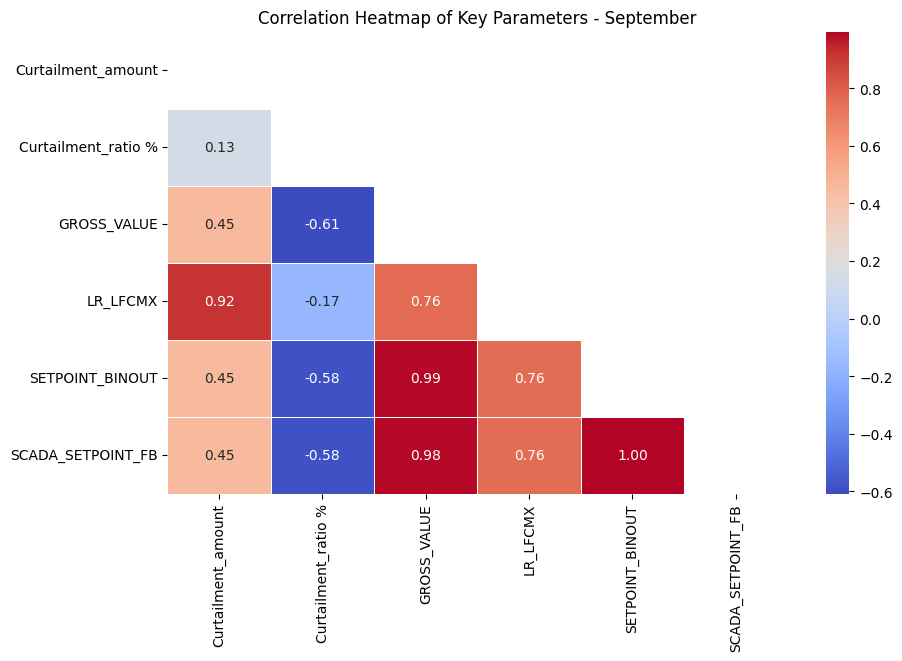

In [152]:
plot_heatmap(df_june, 'June')
plot_heatmap(df_sept, 'September')

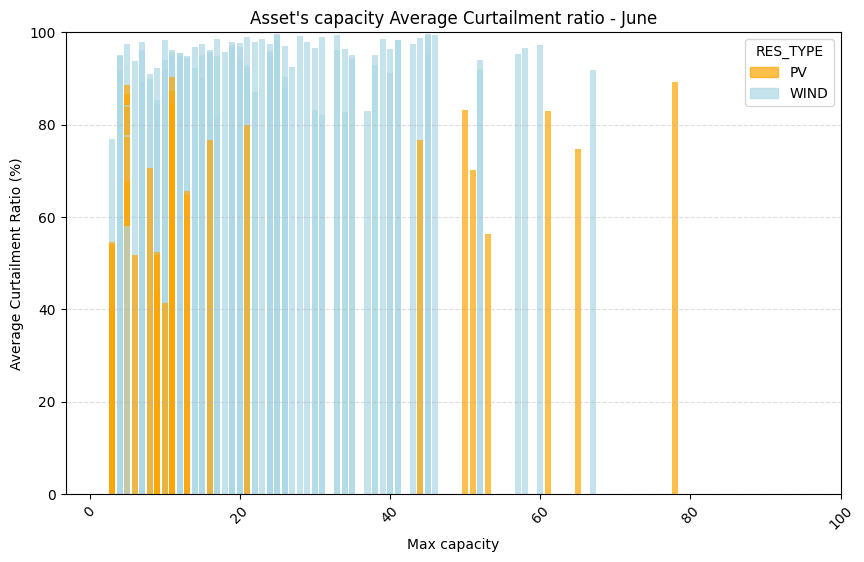

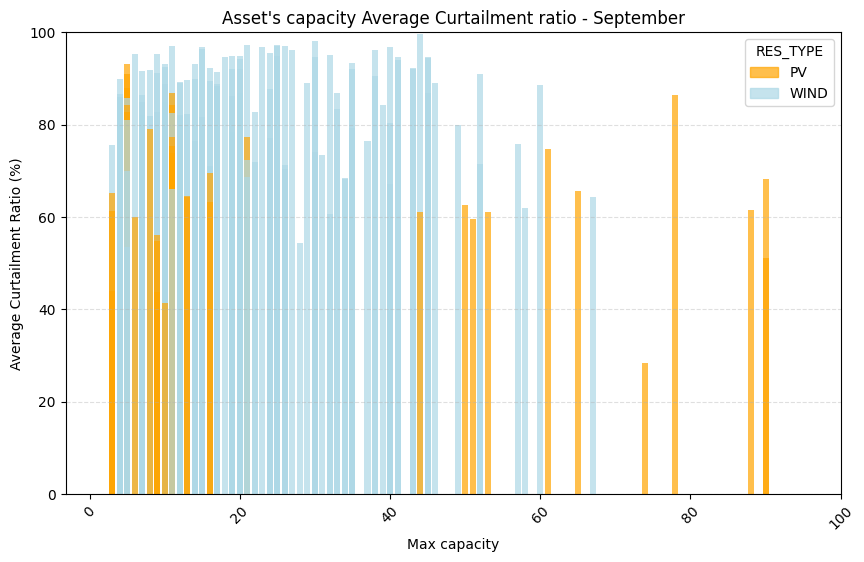

In [153]:
plot_maxcap_avgcr(groups_june, 'June')
plot_maxcap_avgcr(groups_sept, 'September')

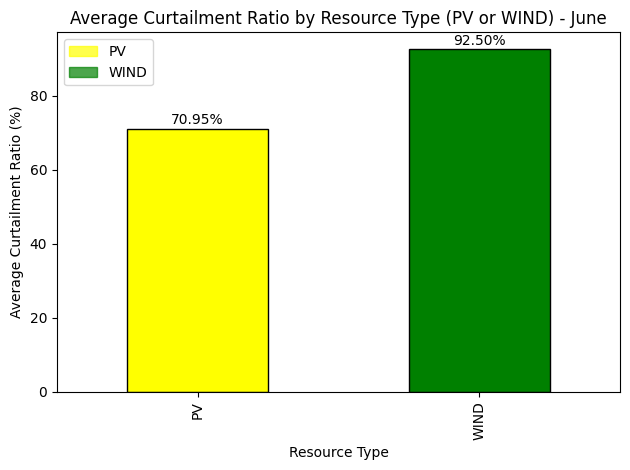

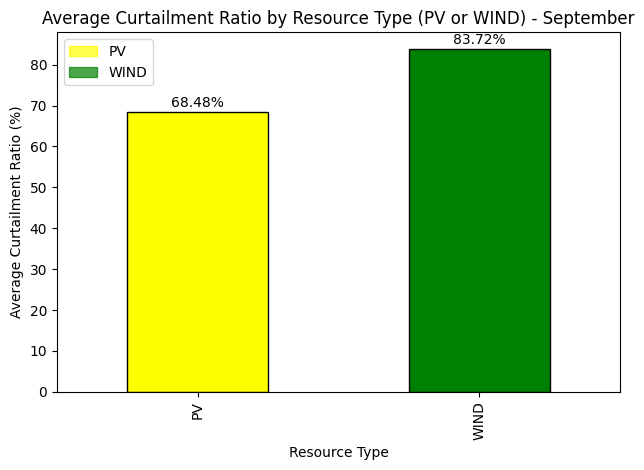

In [154]:
plot_res_avgcr(groups_june, 'June')
plot_res_avgcr(groups_sept, 'September')

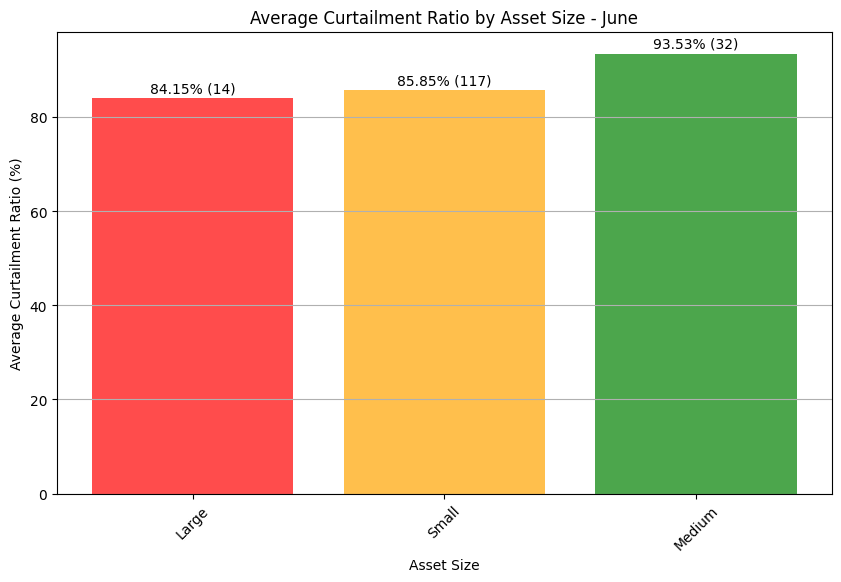

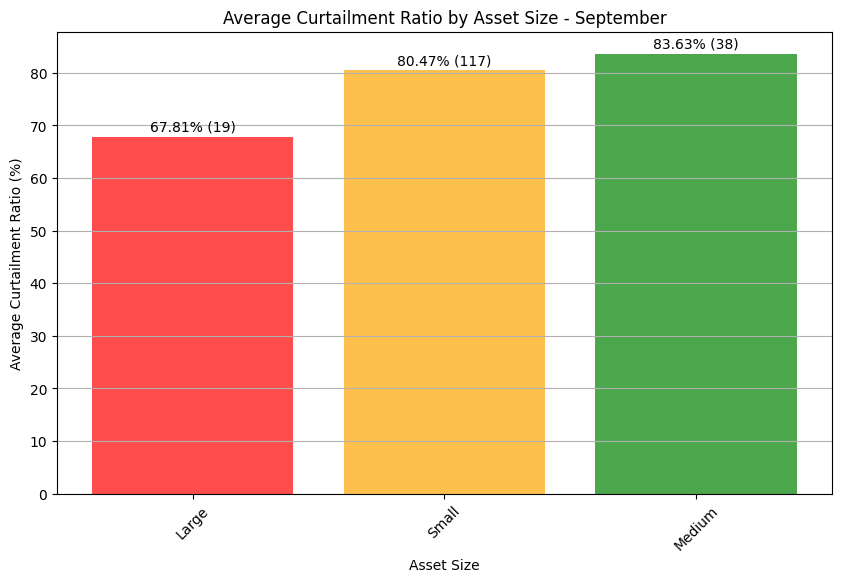

In [155]:
plot_size_curtailment(groups_june, 'June')
plot_size_curtailment(groups_sept, 'September')

C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\52108017.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


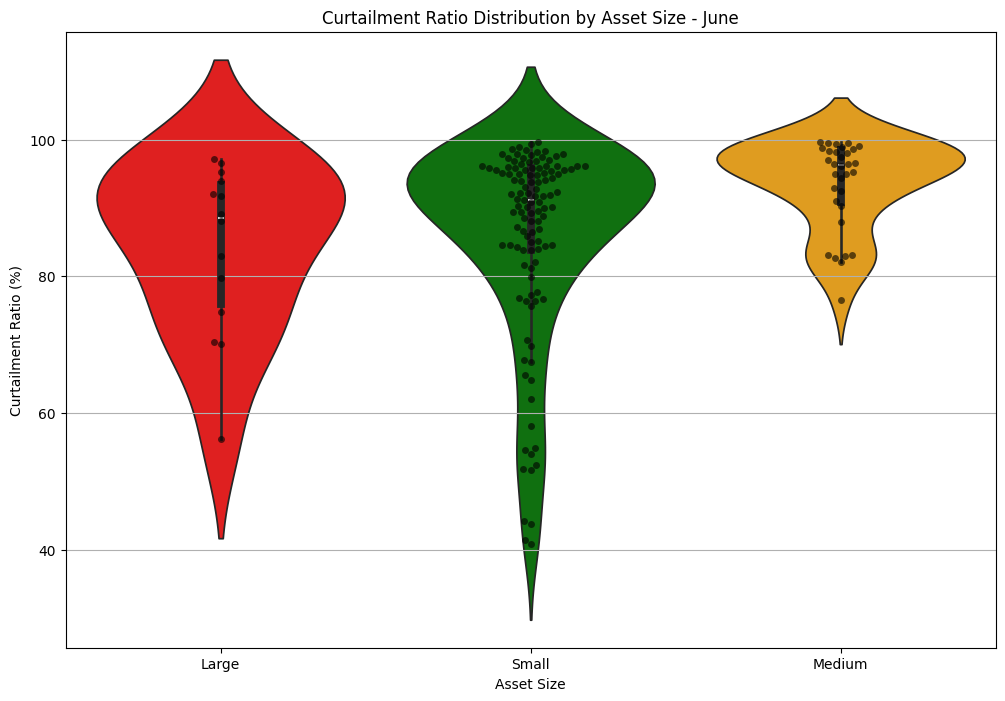

C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\52108017.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


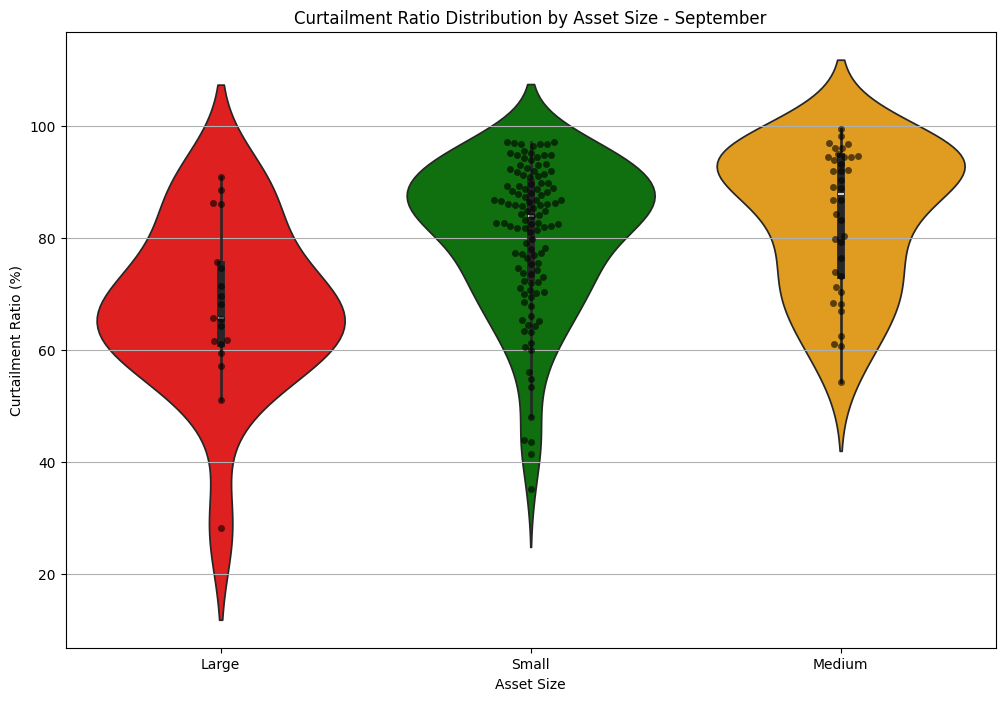

In [156]:
plot_size_curtailment_violin_swarm_plot(groups_june, 'June')
plot_size_curtailment_violin_swarm_plot(groups_sept, 'September')

# Dataset for the RES limit and Available generation

In [157]:
def check_values(df):
    print(len(df))
    print(df.isna().sum())
    df.drop_duplicates(inplace= True)
    print(len(df))
    df.dropna(inplace= True)
    print(len(df))

    return df

In [158]:
df_res = check_values(data_res)

524
START_OF_15MIN_EET      0
RES_LIMIT               0
AVAILABLE_GENERATION    0
dtype: int64
524
524


In [159]:
def extract_exceed_points(df):
    # Filter the DataFrame for rows where available generation exceeds the RES limit
    exceed_points = df[df['AVAILABLE_GENERATION'] > df['RES_LIMIT']]

    # Set 'START_OF_15MIN_EET' as the index
    exceed_points.set_index('START_OF_15MIN_EET', inplace=True)
    
    # Print the relevant columns (timestamp, available generation, and RES limit)
    print("Exceed Points (Time and Available Generation exceeding RES_LIMIT):")
    print(exceed_points[['AVAILABLE_GENERATION', 'RES_LIMIT']])
    
    return exceed_points



In [160]:

def plot_exceeding_points(df):
    # Ensure the index is datetime
    df.index = pd.to_datetime(df.index)

    # Filter for months June (6) to September (9)
    df_filtered = df[df.index.month.isin([6, 7, 8, 9])]

    # Identify exceeding points
    exceed_mask = df_filtered['AVAILABLE_GENERATION'] > df_filtered['RES_LIMIT']
    df_exceeding = df_filtered[exceed_mask]

    # Calculate the deviation
    df_exceeding['Deviation'] = df_exceeding['AVAILABLE_GENERATION'] - df_exceeding['RES_LIMIT']

    # Plot the data
    plt.figure(figsize=(12, 6))

    # Scatter plot for all points
    plt.scatter(df_filtered.index, df_filtered['AVAILABLE_GENERATION'], color='blue', label='Available Generation')
    plt.scatter(df_filtered.index, df_filtered['RES_LIMIT'], color='red', label='RES Limit')

    # Highlight exceed points
    plt.scatter(df_exceeding.index, df_exceeding['AVAILABLE_GENERATION'], color='purple', label='Exceeding Points')

    # Draw deviation lines
    for idx, row in df_exceeding.iterrows():
        plt.plot([idx, idx], [row['RES_LIMIT'], row['AVAILABLE_GENERATION']], color='orange', linestyle='--')

    # Set plot labels and title
    plt.title('Available Generation vs RES Limit Over Time (June to September)')
    plt.xlabel('Timestamp')
    plt.ylabel('Power (MW)')
    plt.xticks(rotation=45)

    # Add grid and legend
    plt.grid(True)
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

    # Optional: Deviation plot
    plt.figure(figsize=(12, 6))
    plt.bar(df_exceeding.index, df_exceeding['Deviation'], color='orange', label='Deviation (Exceeds)')
    plt.title('Deviation of Available Generation Above RES Limit')
    plt.xlabel('Timestamp')
    plt.ylabel('Deviation (MW)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [161]:
df_exceed_points = extract_exceed_points(df_res)

Exceed Points (Time and Available Generation exceeding RES_LIMIT):
                    AVAILABLE_GENERATION  RES_LIMIT
START_OF_15MIN_EET                                 
01-06-24 13:00                       725        690
01-06-24 14:00                       538        521
02-06-24 10:30                       320        272
02-06-24 10:45                       265        200
02-06-24 11:00                       220        200
...                                  ...        ...
21-09-24 12:00                      1092       1027
21-09-24 12:15                       943        900
21-09-24 12:30                       811        800
21-09-24 14:00                       987        953
21-09-24 14:15                       881        868

[145 rows x 2 columns]


C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\2757057209.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


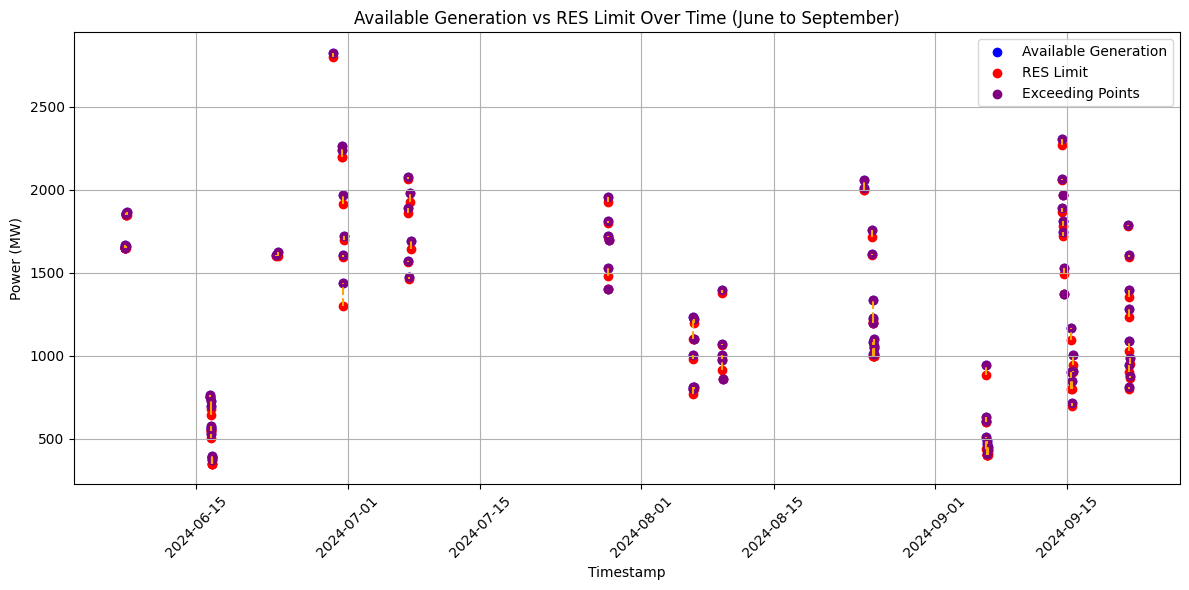

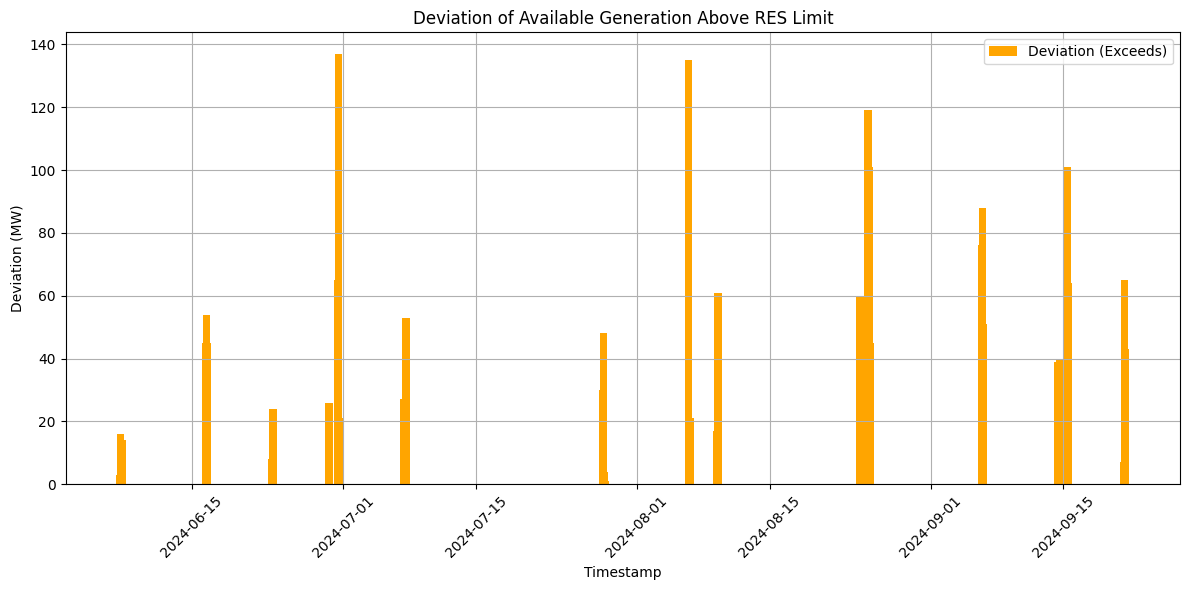

In [162]:
plot_exceeding_points(df_exceed_points)

In [163]:
def group_by_exceed_id_time(df):
    # Calculate Curtailment Metrics
    df['Curtailment_amount'] = df['LR_LFCMX'] - df['GROSS_VALUE']  # Curtailment amount
    df['Curtailment_ratio %'] = (df['Curtailment_amount'] / df['LR_LFCMX']) * 100  # Curtailment ratio percentage
    df['Size'] = df['LR_LFCMX'].apply(lambda x: 'Small' if x <= 25 else 'Medium' if 26 <= x <= 50 else 'Large')
    
    # Remove outliers (values below 0)
    df = df[(df['Curtailment_amount'] > 0) & (df['Curtailment_ratio %'] > 0)]

    # Convert 'HIST_TIMESTAMP' to datetime
    df['HIST_TIMESTAMP'] = pd.to_datetime(df['HIST_TIMESTAMP'], errors='coerce')

    # Identify and drop invalid timestamps
    invalid_timestamps = df[df['HIST_TIMESTAMP'].isna()]
    if not invalid_timestamps.empty:
        print("Found invalid timestamps:")
        print(invalid_timestamps)
    df = df.dropna(subset=['HIST_TIMESTAMP'])

    # Set the 'HIST_TIMESTAMP' column as the index
    df_exceed = df.set_index('HIST_TIMESTAMP')

    # Add a column for 15-minute intervals (round down to nearest 15 minutes)
    df_exceed['15min_interval'] = df_exceed.index.floor('15T')

    # Group by the specified identifiers columns first, then by 15-minute intervals
    identifiers_columns = ['DEVICE_B1_NAME', 'DEVICE_B2_NAME', 'DEVICE_B3_NAME', 'DEVICE_SCADA_B3_NAME', 'RES_TYPE', 'LR_LFCMX']
    
    # Perform the groupby and aggregation
    grouped = df_exceed.groupby(identifiers_columns + ['15min_interval']).agg(
        Avg_curtailment_amount=('Curtailment_amount', 'mean'),  # Average curtailment amount
        Avg_curtailment_ratio=('Curtailment_ratio %', 'mean'),  # Average curtailment ratio
        Avg_gross_value=('GROSS_VALUE', 'mean'),  # Average gross value
        Max_capacity=('LR_LFCMX', 'first'),  # First value of max capacity
        Size=('Size', 'first')  # First value of size
    )

    # Reset index to make it more readable if necessary
    grouped = grouped.reset_index()

    # Print and return the grouped result
    print(grouped)
    return grouped

In [164]:
def group_by_exceed_size(grouped_df, exceed_points_df):
    # Ensure 'START_OF_15MIN_EET' is converted to datetime
    exceed_points_df.index = pd.to_datetime(exceed_points_df.index, errors='coerce')

    results = []

    # Analyze each exceed point
    for exceed_point in exceed_points_df.index:
        # Ensure exceed_point is a Timestamp
        exceed_point = pd.Timestamp(exceed_point)

        # Filter rows at exceed_point and exceed_point + 15 minutes
        time_points = [exceed_point, exceed_point + pd.Timedelta(minutes=15)]
        filtered_data = grouped_df[grouped_df['15min_interval'].isin(time_points)]

        # Skip if no data is found for these points
        if filtered_data.empty:
            continue

        # Group by Size and calculate averages
        grouped = filtered_data.groupby('Size').agg(
            Avg_avg_curtailment_ratio=('Avg_curtailment_ratio', 'mean'),
            Avg_avg_curtailment_amount=('Avg_curtailment_amount', 'mean'),
            Data_Count=('Avg_curtailment_amount', 'count')  # Count of data points
        ).reset_index()

        # Add the exceed point and time offset info to the results
        grouped['Exceed_Point'] = exceed_point
        grouped['Time_Offset'] = grouped['Size'].map(
            lambda size: ['0 minutes', '15 minutes'] if size in filtered_data['Size'].values else []
        )

        results.append(grouped)

    # Combine all results into a single DataFrame
    result_df = pd.concat(results, ignore_index=True) if results else pd.DataFrame()

    print("Results grouped by Size for the two time points (0 and 15 minutes):")
    print(result_df)

    return result_df



In [165]:
def plot_exceed_points_size_barplot(df, month):
    # Ensure Exceed_Point is in datetime format if not already
    df['Exceed_Point'] = pd.to_datetime(df['Exceed_Point'], errors='coerce')
    
    # Drop rows with NaT or invalid Exceed_Point values
    df = df.dropna(subset=['Exceed_Point'])

    # Create a seaborn barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Exceed_Point', y='Avg_avg_curtailment_ratio', hue='Size')

    # Customize the plot
    plt.title(f'Average Curtailment Ratio for Each Exceed Point and Size Group - {month}')
    plt.xlabel('Exceed Point (Timestamp)')
    plt.ylabel('Average Curtailment Ratio %')
    plt.xticks(rotation=45)
    plt.legend(title='Size')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [166]:
group_sept_exceed = group_by_exceed_id_time(data_sept)
group_june_exceed = group_by_exceed_id_time(data_june)

C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\390453186.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['HIST_TIMESTAMP'] = pd.to_datetime(df['HIST_TIMESTAMP'], errors='coerce')
C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\390453186.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HIST_TIMESTAMP'] = pd.to_datetime(df['HIST_TIMESTAMP'], errors='coerce')
C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\390453186.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_exceed['15min_interval'] = d

     DEVICE_B1_NAME DEVICE_B2_NAME DEVICE_B3_NAME DEVICE_SCADA_B3_NAME  \
0          ??.?????            ??1           GFC1             ????????   
1          ??.?????            ??1           GFC1             ????????   
2          ??.?????            ??1           GFC1             ????????   
3          ??.?????            ??1           GFC1             ????????   
4          ??.?????            ??1           GFC1             ????????   
...             ...            ...            ...                  ...   
9827       ?_??????           ???1           GFC1                ?????   
9828       ?_??????           ???1           GFC1                ?????   
9829       ?_??????           ???1           GFC1                ?????   
9830       ?_??????           ???1           GFC1                ?????   
9831       ?_??????           ???1           GFC1                ?????   

     RES_TYPE  LR_LFCMX      15min_interval  Avg_curtailment_amount  \
0          PV        16 2024-01-09 11:00

C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\390453186.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['HIST_TIMESTAMP'] = pd.to_datetime(df['HIST_TIMESTAMP'], errors='coerce')
C:\Users\dzagganas.WINCELL\AppData\Local\Temp\ipykernel_13768\390453186.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_exceed['15min_interval'] = df_exceed.index.floor('15T')


      DEVICE_B1_NAME DEVICE_B2_NAME DEVICE_B3_NAME DEVICE_SCADA_B3_NAME  \
0           ??.?????            ??1           GFC1             ????????   
1           ??.?????            ??1           GFC1             ????????   
2           ??.?????            ??1           GFC1             ????????   
3           ??.?????            ??1           GFC1             ????????   
4           ??.?????            ??1           GFC1             ????????   
...              ...            ...            ...                  ...   
10962       ???_????           ???6           GFIC              ??????2   
10963       ???_????           ???6           GFIC              ??????2   
10964        ?_?????            ??1           GFC1                  ??1   
10965        ?_?????            ??2           GFC1                  ??2   
10966       ?_??????           ???1           GFC1                ?????   

      RES_TYPE  LR_LFCMX      15min_interval  Avg_curtailment_amount  \
0           PV        16 20

In [167]:
result_exceed_size_df_sept = group_by_exceed_size(group_sept_exceed, df_exceed_points)
result_exceed_size_df_june = group_by_exceed_size(group_june_exceed, df_exceed_points)

Results grouped by Size for the two time points (0 and 15 minutes):
      Size  Avg_avg_curtailment_ratio  Avg_avg_curtailment_amount  Data_Count  \
0    Large                  53.415037                   36.935437          39   
1   Medium                  78.519656                   28.732565         106   
2    Small                  78.971118                   10.990912         284   
3    Large                  59.589113                   40.354058          40   
4   Medium                  79.075102                   29.012812         108   
5    Small                  79.205438                   10.931112         297   
6    Large                  62.664234                   43.036614          42   
7   Medium                  81.150834                   29.720801         107   
8    Small                  80.830208                   11.211880         293   
9    Large                  65.460190                   46.116706          42   
10  Medium                  85.536813    

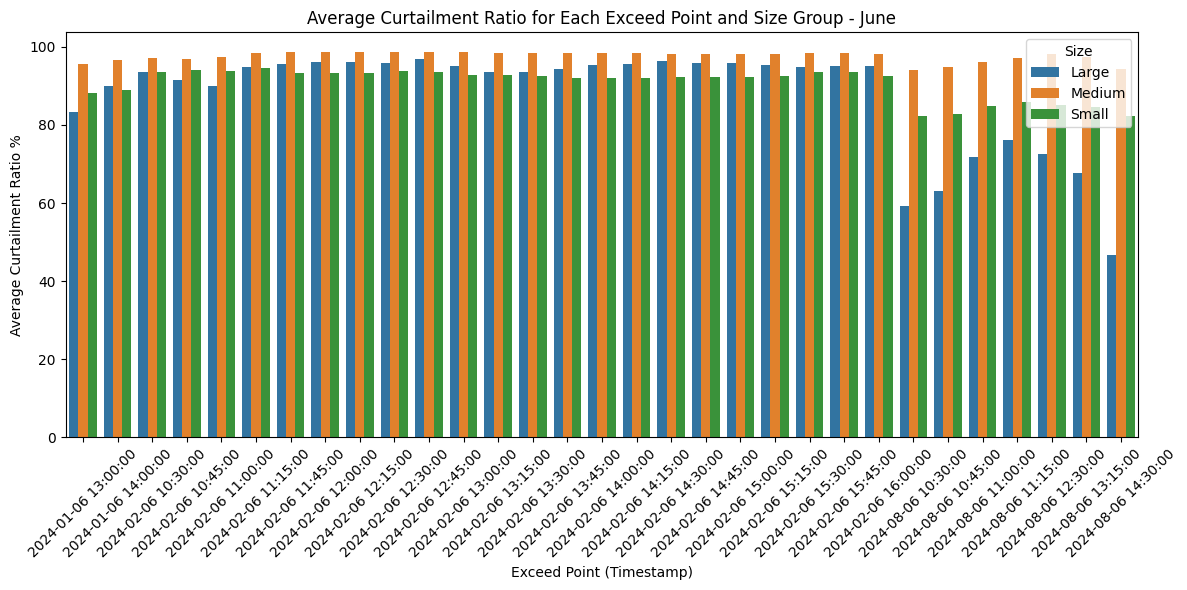

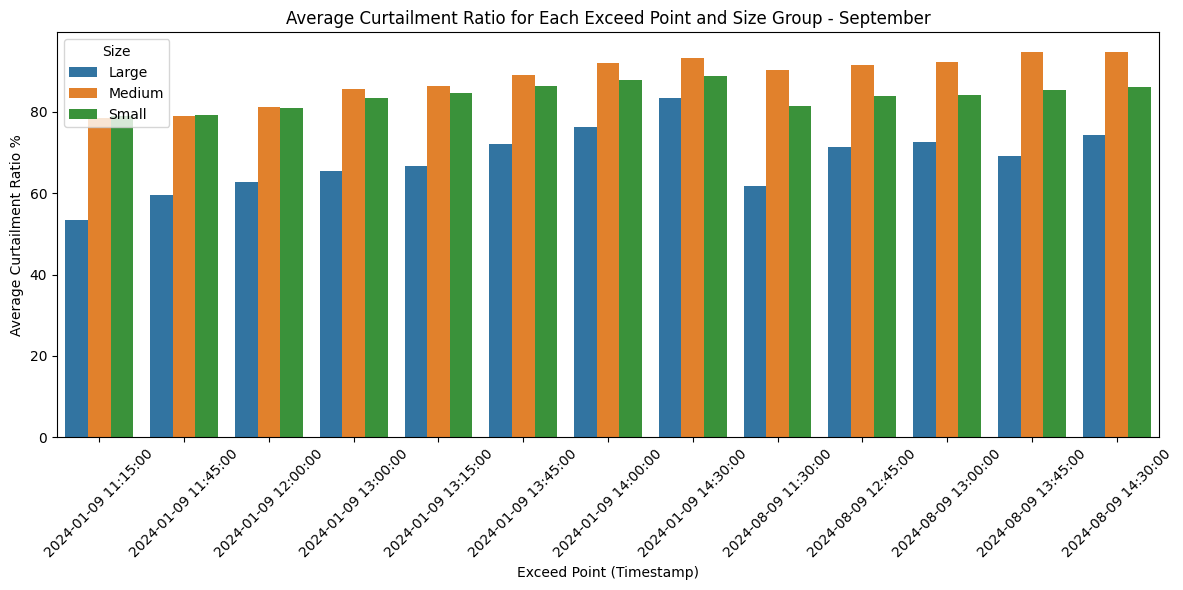

In [168]:
plot_exceed_points_size_barplot(result_exceed_size_df_june, 'June')
plot_exceed_points_size_barplot(result_exceed_size_df_sept, 'September')

In [169]:
def group_by_exceed_res_type(grouped_df, exceed_points_df):
    # Ensure 'START_OF_15MIN_EET' is converted to datetime
    exceed_points_df.index = pd.to_datetime(exceed_points_df.index, errors='coerce')

    results = []

    # Analyze each exceed point
    for exceed_point in exceed_points_df.index:
        # Ensure exceed_point is a Timestamp
        exceed_point = pd.Timestamp(exceed_point)

        # Filter rows at exceed_point and exceed_point + 15 minutes
        time_points = [exceed_point, exceed_point + pd.Timedelta(minutes=15)]
        filtered_data = grouped_df[grouped_df['15min_interval'].isin(time_points)]

        # Skip if no data is found for these points
        if filtered_data.empty:
            continue

        # Group by RES_TYPE and calculate averages
        grouped = filtered_data.groupby('RES_TYPE').agg(
            Avg_avg_curtailment_ratio=('Avg_curtailment_ratio', 'mean'),
            Avg_avg_curtailment_amount=('Avg_curtailment_amount', 'mean'),
            Data_Count=('Avg_curtailment_amount', 'count')  # Count of data points
        ).reset_index()

        # Add the exceed point and time offset info to the results
        grouped['Exceed_Point'] = exceed_point
        grouped['Time_Offset'] = grouped['RES_TYPE'].map(
            lambda res_type: ['0 minutes', '15 minutes'] if res_type in filtered_data['RES_TYPE'].values else []
        )

        results.append(grouped)

    # Combine all results into a single DataFrame
    result_df = pd.concat(results, ignore_index=True) if results else pd.DataFrame()

    print("Results grouped by RES_TYPE for the two time points (0 and 15 minutes):")
    print(result_df)

    return result_df


In [170]:
def plot_exceed_points_res_type_barplot(df, month):
    # Ensure Exceed_Point is in datetime format if not already
    df['Exceed_Point'] = pd.to_datetime(df['Exceed_Point'], errors='coerce')
    
    # Drop rows with NaT or invalid Exceed_Point values
    df = df.dropna(subset=['Exceed_Point'])

    # Create a seaborn barplot, grouping by 'Exceed_Point' and coloring by 'RES_TYPE'
    plt.figure(figsize=(14, 8))
    sns.barplot(data=df, x='Exceed_Point', y='Avg_avg_curtailment_ratio', hue='RES_TYPE')

    # Customize the plot
    plt.title(f'Average Curtailment Ratio for Each Exceed Point and RES_TYPE - {month}')
    plt.xlabel('Exceed Point (Timestamp)')
    plt.ylabel('Average Curtailment Ratio %')
    plt.xticks(rotation=45)  # Rotate x-axis labels to make them readable
    plt.legend(title='RES_TYPE')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [171]:
result_df_res_type_sept = group_by_exceed_res_type(group_sept_exceed, df_exceed_points)
result_df_res_type_june = group_by_exceed_res_type(group_june_exceed, df_exceed_points)


Results grouped by RES_TYPE for the two time points (0 and 15 minutes):
   RES_TYPE  Avg_avg_curtailment_ratio  Avg_avg_curtailment_amount  \
0        PV                  59.636707                   16.178933   
1      WIND                  80.773501                   18.122929   
2        PV                  63.404678                   16.242802   
3      WIND                  81.110954                   18.419050   
4        PV                  66.594581                   18.324512   
5      WIND                  82.627674                   18.823965   
6        PV                  72.056236                   20.524737   
7      WIND                  85.112635                   19.263276   
8        PV                  73.955201                   21.314621   
9      WIND                  85.953489                   19.477810   
10       PV                  76.285733                   22.436878   
11     WIND                  88.268898                   20.041199   
12       PV       

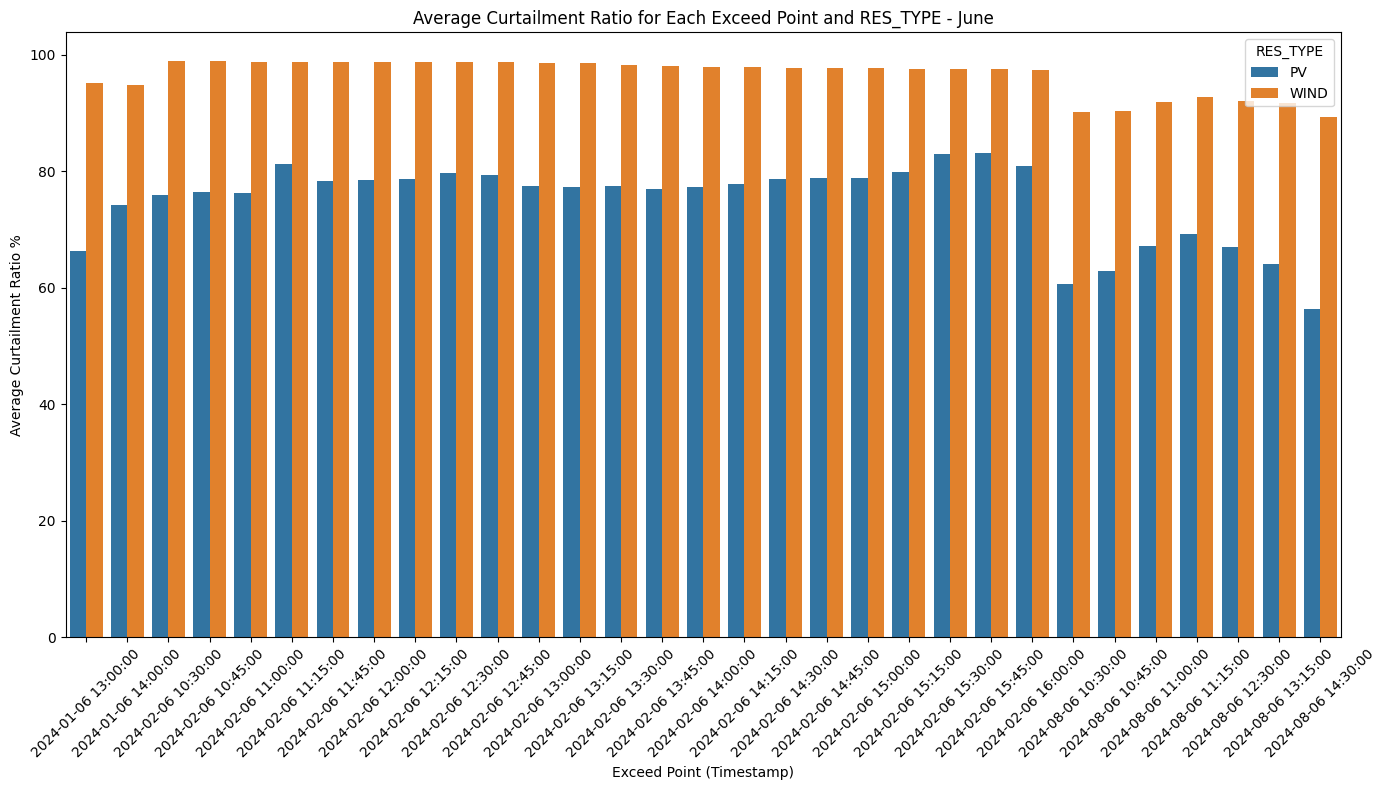

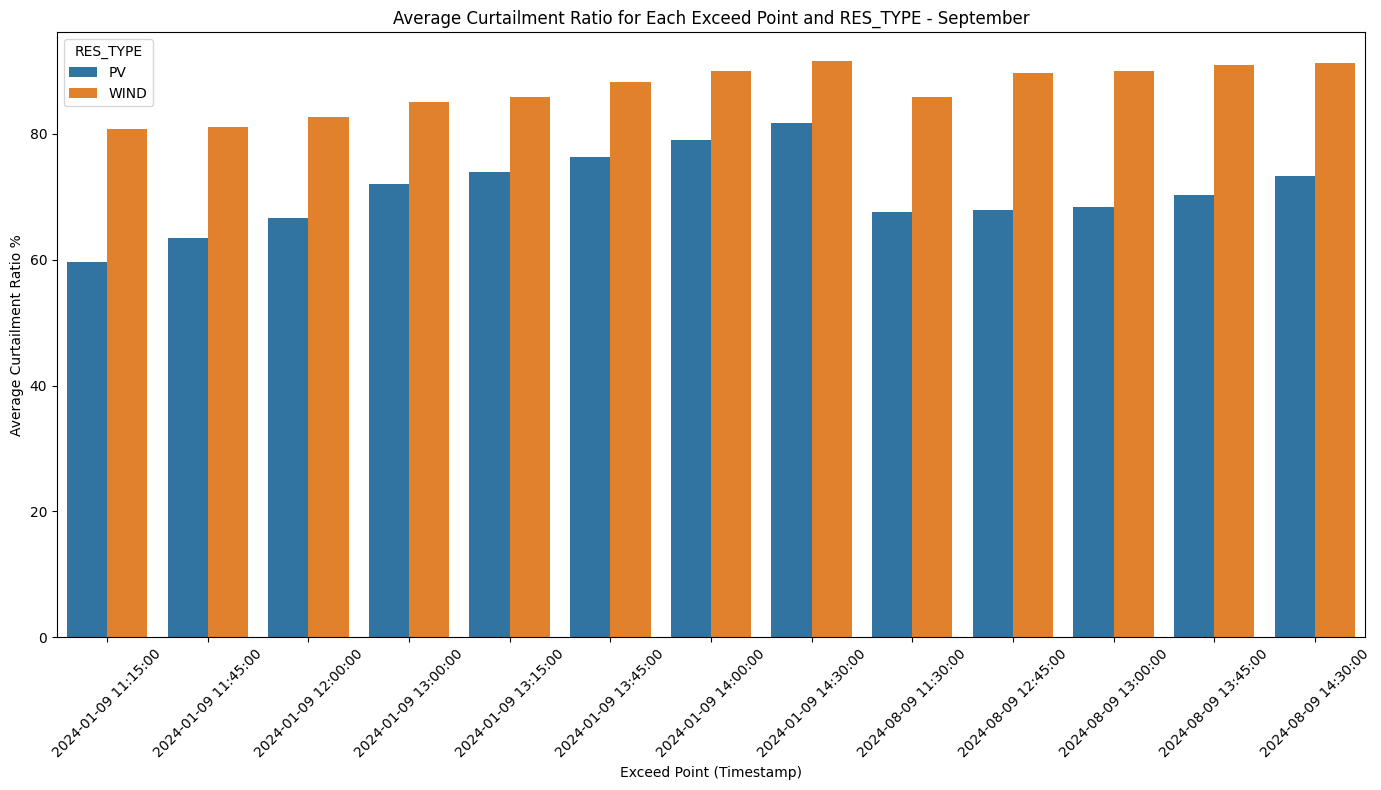

In [172]:
plot_exceed_points_res_type_barplot(result_df_res_type_june, 'June')
plot_exceed_points_res_type_barplot(result_df_res_type_sept, 'September')